<a href="https://colab.research.google.com/github/cswcjt/Dacon_Bike/blob/main/TFT_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture 
!pip install torch pytorch-lightning pytorch_forecasting

In [ ]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Extented Time-Series Format

In [ ]:
sample_data = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


In [ ]:
# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    sample_data,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

# pass the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=1)

#load the first batch
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[41., 42.]])
tensor([[2]])


tensor([[43., 44., 45.]])


# Energy Demand Forecasting with Temporal Fusion Transformer

### Download the dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip

--2022-12-09 10:30:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261335609 (249M) [application/x-httpd-php]
Saving to: ‘LD2011_2014.txt.zip.1’

LD2011_2014.txt.zip 100%[===================>] 249.23M  17.3MB/s    in 15s     

2022-12-09 10:31:09 (16.3 MB/s) - ‘LD2011_2014.txt.zip.1’ saved [261335609/261335609]

Archive:  LD2011_2014.txt.zip
replace LD2011_2014.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Data Preprocessing

### 1) Each column represents a consumer. 

In [ ]:
data = pd.read_csv('LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.tail(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


### 2) we aggregate to hourly data

In [ ]:
 # 0을 nan으로 처리하네
data = data.resample('1h').mean().replace(0., np.nan) 

# 데이터의 시작 시점을 기억
earliest_time = data.index.min() 

# 빠른 계산을 위해 고객 5명에 대한 데이터만 사용 
df=data[['MT_002',	'MT_004',	'MT_005',	'MT_006',	'MT_008' ]] # -> 5명만 가지고 확인

### 3) Now, we prepare our dataset for the TimeSeriesDataset format. 

- Notice that each column represents a different time-series. 
- we ‘melt’ our dataframe, so that all time-series are stacked vertically instead of horizontally.

- since the granularity is hourly, the hours_from_start variable will be the time index.

In [ ]:
df_list = []

for label in df:
    # label = consumer
    ts = df[label]
    # display(ts)
    
    # 시작날짜, 마지막날짜 저장
    start_date = min(ts.fillna(method='ffill').index)
    end_date = max(ts.fillna(method='bfill').index)
    #print(start_date, end_date)

    # active_range = 시작날짜부터 마지막날짜까지
    # ts = 각 고객이 사용한 전력 총량의 시계열 데이터
    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)
    # display(ts)

    # tmp 생성
    # date도 생성 -> month, day, hour 등 시간에 관련 된 모든 데이터 갖고있다.
    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    # 시간 변화에 대한 정보들 컬럼으로 만들어 준다.
    # (date - earliest_time).seconds / 60 / 60 -> 초를 시간으로 
    # (date - earliest_time).days * 24 -> 날짜를 시간으로 
    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
    tmp['days_from_start'] = (date - earliest_time).days

    # 시간 자체에 대한 정보들 컬럼들도 만들어 준다.  
    tmp['date'] = date
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    # 고객정보 컬럼도 만들어준다. 
    tmp['consumer_id'] = label

    # stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)
# time_df

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()

time_df

,power_usage,hours_from_start,days_from_start,date,hour,day,day_of_week,month,consumer_id
26304,24.004267,26304,1096,2014-01-01 00:00:00,0,1,2,1,MT_002
26305,23.293030,26305,1096,2014-01-01 01:00:00,1,1,2,1,MT_002
26306,24.537696,26306,1096,2014-01-01 02:00:00,2,1,2,1,MT_002
26307,21.870555,26307,1096,2014-01-01 03:00:00,3,1,2,1,MT_002
26308,22.226174,26308,1096,2014-01-01 04:00:00,4,1,2,1,MT_002
...,...,...,...,...,...,...,...,...,...
172559,249.158249,32299,1345,2014-09-07 19:00:00,19,7,6,9,MT_008
172560,303.030303,32300,1345,2014-09-07 20:00:00,20,7,6,9,MT_008
172561,306.397306,32301,1345,2014-09-07 21:00:00,21,7,6,9,MT_008
172562,279.461279,32302,1345,2014-09-07 22:00:00,22,7,6,9,MT_008


### Exploratory Data Analysis

- notice that other time-series forecasting methods like ARIMA must satisfy a few requirements (for instance, the time-series must first become stationary.) 
- With TFT, we can leave our data as-is.

In [ ]:
time_df.query("hours_from_start==26304")

,power_usage,hours_from_start,days_from_start,date,hour,day,day_of_week,month,consumer_id
26304,24.004267,26304,1096,2014-01-01,0,1,2,1,MT_002
61369,148.882114,26304,1096,2014-01-01,0,1,2,1,MT_004
96434,75.609756,26304,1096,2014-01-01,0,1,2,1,MT_005
131499,276.041667,26304,1096,2014-01-01,0,1,2,1,MT_006
166564,247.474747,26304,1096,2014-01-01,0,1,2,1,MT_008


In [ ]:
time_df[['consumer_id','power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.rcParams.update(plt.rcParamsDefault)
sns.set_style('darkgrid')
sns.color_palette("tab10")

fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(data=time_df[time_df['month'] == 1], 
             x='date', 
             y='power_usage', 
             hue='consumer_id', 
             legend='full',
             palette='husl').set_title('Power usage per consumers')

ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
ax.set_ylabel("Power usage (KWs)", fontdict={"color":  "black", "size": 13})
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Power usage of consumers", fontdict={"color":  "black", "size": 15})

### Data Preparation

- Our example model uses a lookback window of one week (7*24) to predict the power usage of the next 24 hours.

In [ ]:
time_df#.head(5)

,power_usage,hours_from_start,days_from_start,date,hour,day,day_of_week,month,consumer_id
26304,24.004267,26304,1096,2014-01-01 00:00:00,0,1,2,1,MT_002
26305,23.293030,26305,1096,2014-01-01 01:00:00,1,1,2,1,MT_002
26306,24.537696,26306,1096,2014-01-01 02:00:00,2,1,2,1,MT_002
26307,21.870555,26307,1096,2014-01-01 03:00:00,3,1,2,1,MT_002
26308,22.226174,26308,1096,2014-01-01 04:00:00,4,1,2,1,MT_002
...,...,...,...,...,...,...,...,...,...
172559,249.158249,32299,1345,2014-09-07 19:00:00,19,7,6,9,MT_008
172560,303.030303,32300,1345,2014-09-07 20:00:00,20,7,6,9,MT_008
172561,306.397306,32301,1345,2014-09-07 21:00:00,21,7,6,9,MT_008
172562,279.461279,32302,1345,2014-09-07 22:00:00,22,7,6,9,MT_008


In [ ]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

# 24시간에 대한 전력 사용량 예측
max_prediction_length = 24

# 일주일을 lookback window 로 설정: 7*24  
max_encoder_length = 7*24

# train data 설정
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length
training = TimeSeriesDataSet(
    # train dataframe 설정
    # idx 설정
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",

    # target 설정
    target="power_usage",

    # 그룹 설정
    group_ids=["consumer_id"],

    # encoder, prediciton
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    # 각 컬럼이 어떤 유형의 변수인지 구분
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],

    # we normalize by group
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
time_df['consumer_id'].value_counts()

MT_002    6000
MT_004    6000
MT_005    6000
MT_006    6000
MT_008    6000
Name: consumer_id, dtype: int64

The **training.index** and **validation.index** show how our training and validation instances are sliced.   
For example, **sequence_length**= **max_encoder_length** + **max_prediction_length**

In [ ]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
5808,26304,32303,1,5808,32112,6000,0,5999,192
11808,26304,32303,1,11808,32112,6000,1,11999,192
17808,26304,32303,1,17808,32112,6000,2,17999,192
23808,26304,32303,1,23808,32112,6000,3,23999,192
29808,26304,32303,1,29808,32112,6000,4,29999,192


### Baseline Model

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


25.139617919921875

### Build TFT model

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 5.134


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.085 >= min_delta = 0.0001. New best score: 4.049


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.242 >= min_delta = 0.0001. New best score: 3.806


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.258 >= min_delta = 0.0001. New best score: 3.548


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 3.548. Signaling Trainer to stop.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_1/checkpoints/epoch=9-step=4680.ckpt


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


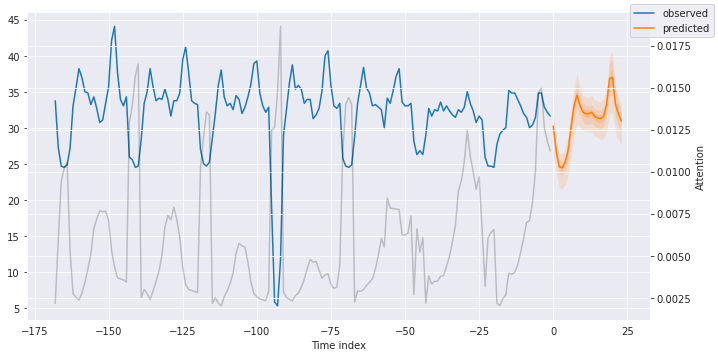

In [ ]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints

encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]

#decoder_data is the new dataframe for which we will create predictions. 
#decoder_data df should be max_prediction_length*consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns

decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
# tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
# tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
# tmp['days_from_start'] = (date - earliest_time).days

decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" consumer_id == 'MT_002'")
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

In [ ]:
decoder_data

,power_usage,hours_from_start,days_from_start,date,hour,day,day_of_week,month,consumer_id
0,31.650071,32304,1345,2014-09-08 00:00:00,0,8,0,9,MT_002
1,136.686992,32304,1345,2014-09-08 00:00:00,0,8,0,9,MT_004
2,54.573171,32304,1345,2014-09-08 00:00:00,0,8,0,9,MT_005
3,162.946429,32304,1345,2014-09-08 00:00:00,0,8,0,9,MT_006
4,250.841751,32304,1345,2014-09-08 00:00:00,0,8,0,9,MT_008
...,...,...,...,...,...,...,...,...,...
115,31.650071,32327,1345,2014-09-08 23:00:00,23,8,0,9,MT_002
116,136.686992,32327,1345,2014-09-08 23:00:00,23,8,0,9,MT_004
117,54.573171,32327,1345,2014-09-08 23:00:00,23,8,0,9,MT_005
118,162.946429,32327,1345,2014-09-08 23:00:00,23,8,0,9,MT_006
